<a name="top" id="top"></a>

<div align="center">
    <h1>Benchmarking</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Universities Space Research Association</i>
    <br>
    <i>NASA QuAIL</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <i>PSR Energy Consulting &amp; Analytics</i>
    <br>
    <br>
    <a href="https://github.com/murraybj">Benjamin J. L. Murray</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Undergraduate Research Assistant</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/QUBONotebooks/blob/main/notebooks_py/5-Benchmarking_python.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="#installation">
        <img src="https://img.shields.io/badge/⚙️-Installation_Instructions-blue" alt="Installation Instructions"/>
    </a>
    <a href="https://bernalde.github.io/">
        <img src="https://img.shields.io/badge/⚗️-Bernal_Lab-blue" alt="Bernal Lab"/>
    </a>
</div>

## About this Notebook

With the new availability of unconventional hardware, novel algorithms, and increasingly optimized software to address optimization problems; the first question that arises is, which one is better?
We will call the combination of hardware, algorithm, and software within a solution method as a solver.
This question is also relevant when evaluating a single solver, given that usually they rely on hyperparameters, for which the quesiton now becomes into, which is the best parameter setting for a given solver?
These questions obviously depend on the problem that one is trying to solve. The solution of the problem also depends on the budget of resources that one has available.

In the case that the available resources are relatively "unlimited" and that the problem to solve is known, one could exhaustively try all the parameter settings within a delimited range for that instance and choose which one is the best.
This case is idealistic, in the sense that usually one does not know a-priori which problem is there to solve (and if while testing all the parameters you solve it, what would be the point of identifying the best parameters?), and that there exists limitations in terms of resources, e.g., time, memory, or energy, when trying to address these problems.
A case closer to reality is where you have the chance of solving problems that look similar to the one that you are interested in solving later, either because you have previously generated problems or you have identified a feature that characterizes your problem of interest and can generate random instances, which we will call as a family of instances.
Then, you can use a larger amount of resources to solve that family of problems "off-line", meaning that you spend extra resources to address the problems in your family of instances although it is unrelated to the actual application.
Finally, you would like to use the results that you found off-line as a guidance to solve your unknown problem more efficiently.

## Example
For illustration purposes, we will use an example that you are already familiar with, which is an Ising model.
As a solver, we will use the **[PySA](https://github.com/nasa/pysa)** simulated annealing code.

In [2]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install with dimod and neal
if IN_COLAB:
    !pip install -q pyomo
    !pip install dimod
    !pip install dwave-neal

In [12]:
# Import the Pyomo library, which can be installed via pip, conda or from Github https://github.com/Pyomo/pyomo
import pyomo.environ as pyo
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx

### Example

Suppose we have an Ising model defined from

$$
h = \begin{bmatrix}
145.0 \\ 122.0 \\ 122.0 \\ 266.0 \\ 266.0 \\ 266.0 \\ 242.5 \\ 266.0 \\ 386.5 \\ 387.0 \\ 386.5
\end{bmatrix},
J = \begin{bmatrix}
0 & 0 & 0 & 24 & 24 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 48 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix} \text{ and }
\beta = 1319.5
$$
Let's solve this problem

In [5]:
# These could also be simple lists and numpy matrices
h = {0: 145.0, 1: 122.0, 2: 122.0, 3: 266.0, 4: 266.0, 5: 266.0, 6: 242.5, 7: 266.0, 8: 386.5, 9: 387.0, 10: 386.5}
J = {(0, 3): 24.0, (0, 4): 24.0, (0, 5): 24.0, (0, 7): 24.0, (0, 8): 24.0, (0, 9): 24.0, (0, 10): 24.0, (1, 3): 24.0, (1, 5): 24.0, (1, 6): 24.0, (1, 8): 24.0, (1, 9): 24.0, (1, 10): 24.0, (2, 4): 24.0, (2, 6): 24.0, (2, 7): 24.0, (2, 8): 24.0, (2, 9): 24.0, (2, 10): 24.0, (3, 4): 24.0, (3, 5): 48.0, (3, 6): 24.0, (3, 7): 24.0, (3, 8): 48.0, (3, 9): 48.0, (3, 10): 48.0, (4, 5): 24.0, (4, 6): 24.0, (4, 7): 48.0, (4, 8): 48.0, (4, 9): 48.0, (4, 10): 48.0, (5, 6): 24.0, (5, 7): 24.0, (5, 8): 48.0, (5, 9): 48.0, (5, 10): 48.0, (6, 7): 24.0, (6, 8): 48.0, (6, 9): 48.0, (6, 10): 48.0, (7, 8): 48.0, (7, 9): 48.0, (7, 10): 48.0, (8, 9): 72.0, (8, 10): 72.0, (9, 10): 72.0}
cI = 1319.5

model_ising = dimod.BinaryQuadraticModel.from_ising(h, J, offset=cI)
print(model_ising)

BinaryQuadraticModel({0: 145.0, 3: 266.0, 4: 266.0, 5: 266.0, 7: 266.0, 8: 386.5, 9: 387.0, 10: 386.5, 1: 122.0, 6: 242.5, 2: 122.0}, {(3, 0): 24.0, (4, 0): 24.0, (4, 3): 24.0, (5, 0): 24.0, (5, 3): 48.0, (5, 4): 24.0, (7, 0): 24.0, (7, 3): 24.0, (7, 4): 48.0, (7, 5): 24.0, (8, 0): 24.0, (8, 3): 48.0, (8, 4): 48.0, (8, 5): 48.0, (8, 7): 48.0, (9, 0): 24.0, (9, 3): 48.0, (9, 4): 48.0, (9, 5): 48.0, (9, 7): 48.0, (9, 8): 72.0, (10, 0): 24.0, (10, 3): 48.0, (10, 4): 48.0, (10, 5): 48.0, (10, 7): 48.0, (10, 8): 72.0, (10, 9): 72.0, (1, 3): 24.0, (1, 5): 24.0, (1, 8): 24.0, (1, 9): 24.0, (1, 10): 24.0, (6, 3): 24.0, (6, 4): 24.0, (6, 5): 24.0, (6, 7): 24.0, (6, 8): 48.0, (6, 9): 48.0, (6, 10): 48.0, (6, 1): 24.0, (2, 4): 24.0, (2, 7): 24.0, (2, 8): 24.0, (2, 9): 24.0, (2, 10): 24.0, (2, 6): 24.0}, 1319.5, 'SPIN')


Let's solve this problem using Simulated Annealing

In [13]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model_ising, num_reads=1000)

In [14]:
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]
    
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))

def plot_energies(results, title=None):
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))


minimum energy: 5.0


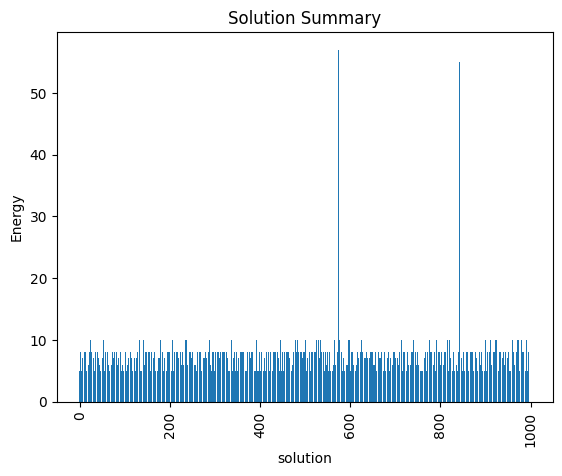

In [15]:
plot_enumerate(simAnnSamples, title='Solution Summary')

We are going to use the default limits of temperature given by the simulating annealing code. These are defined using the minimum and maximum nonzero coefficients in the Ising model. Then the range for beta is defined as 

$$
\beta \in \left[ \frac{\log(2)}{\max \{ \Delta E \} },\frac{\log(100)}{\min \{ \Delta E \} } \right]
$$

where

$$
\Delta E = \min_{i} \{h_i \} + \sum_j J_{ij}+J_{ji}
$$

Hot temperature: We want to scale hot_beta so that for the most unlikely qubit flip, we get at least 50% chance of flipping. (This means all other qubits will have > 50% chance of flipping initially). Most unlikely flip is when we go from a very low energy state to a high energy state, thus we calculate hot_beta based on max_delta_energy.

$$
0.50 = \exp(-\overline{\beta} * \max \{ \Delta E \})
$$

Cold temperature: Towards the end of the annealing schedule, we want to minimize the chance of flipping. Don't want to be stuck between small energy tweaks. Hence, set cold_beta so that at minimum energy change, the chance of flipping is set to 1%.

$$
0.01 = \exp(-\underline{\beta} * \min \{ \Delta E \})
$$

By default, the schedule also follows a geometric series.

In [26]:
def geomspace(a, b, length=100):
    return np.logspace(np.log10(a), np.log10(b), num=length, endpoint=True)

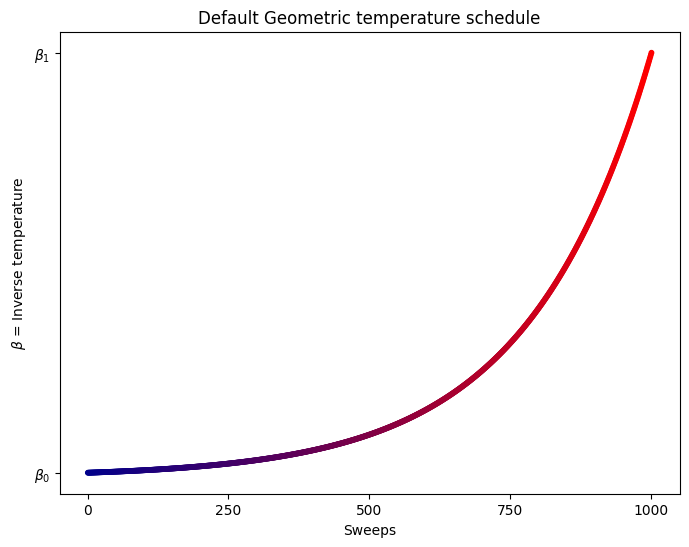

In [55]:
def hex_to_RGB(hex_str):
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

def plot_schedule(beta1, beta2, length=1000):
    color1 = "#00008b"
    color2 = "#ff0000"
    sweeps = np.linspace(np.log10(2), np.log10(100), num=length, endpoint=True)
    beta = np.geomspace(beta1, beta2, num=length)
    plt.figure(figsize=(8, 6))
    plt.scatter(x=sweeps, 
                y=beta, 
                color = get_color_gradient(color1, color2, len(beta)), 
                s=10)
    plt.title("Default Geometric temperature schedule")
    plt.xlabel("Sweeps")
    plt.ylabel(r"$ \beta $ = Inverse temperature")
    plt.xticks([sweeps[0], sweeps[249], sweeps[499], sweeps[749], sweeps[999]], [0,250,500,750,1000])
    plt.yticks([beta1, beta2], [r"$ \beta_{0} $", r"$ \beta_{1} $"])
    plt.grid(False)
    plt.show()
    

# Example usage:
beta1 = 0.1
beta2 = 10
plot_schedule(beta1, beta2)


In [16]:
simAnnSamples.info

{'beta_range': [0.00041111932417553103, 0.1458971970580513],
 'beta_schedule_type': 'geometric',
 'timing': {'preprocessing_ns': 46796200,
  'sampling_ns': 284678300,
  'postprocessing_ns': 1844400}}

Now let's compute an expected time metric with respect to the number of sweeps in simulated annealing.

In [17]:
s = 0.99
sweeps = list(chain(np.arange(1,10,1),np.arange(10,30,2), np.arange(30,50,5), np.arange(50,100,10) ,np.arange(100,1001,100)))
schedules = ['geometric','linear']
opt_energy = [5]
p = {}
tts = {}
for schedule in schedules:
    probs = []
    time_to_sol = []
    for sweep in sweeps:
        start = time.time()
        samples = simAnnSampler.sample(model_ising, num_reads=1000, num_sweeps=sweep, beta_schedule_type=schedule)
        if sweep == 1:
            tau = time.time() - start
        energies=samples.data_vectors['energy']
        occurrences = samples.data_vectors['num_occurrences']
        total_counts = sum(occurrences)
        counts = {}
        for index, energy in enumerate(energies):
            if energy in counts.keys():
                counts[energy] += occurrences[index]
            else:
                counts[energy] = occurrences[index]
        pr = sum(counts[key] for key in opt_energy if key in counts.keys())/total_counts
        probs.append(pr)
        time_to_sol.append(sweep*tau*math.log10(1-s)/math.log10(1-pr))
    p[schedule] = probs
    tts[schedule] = time_to_sol

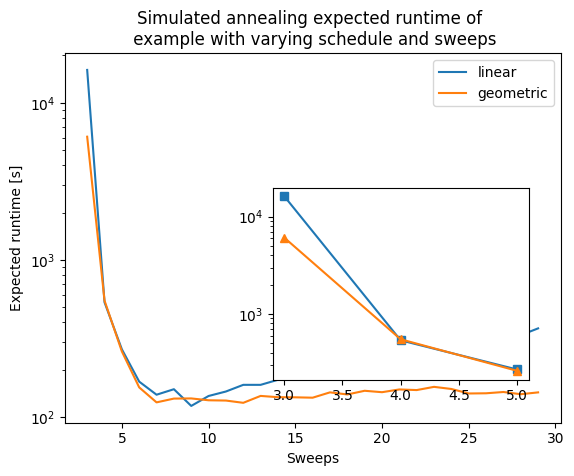

In [56]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.semilogy(sweeps,tts['linear'],'-', label='linear')
ax1.semilogy(sweeps,tts['geometric'],'-', label='geometric')
plt.ylabel('Expected runtime [s]')
plt.xlabel('Sweeps')
plt.title('Simulated annealing expected runtime of \n' + ' example with varying schedule and sweeps')
plt.legend()

ax2 = plt.axes([.45, .2, .4, .4])
ax2.semilogy(sweeps[0:5],tts['linear'][0:5],'-s')
ax2.semilogy(sweeps[0:5],tts['geometric'][0:5],'-^')


In [19]:
import numpy as np

# Number of variables
N = 100

# Fixing the random seed to get the same result
np.random.seed(1)

# We only consider upper triangular matrix ignoring the diagonal
J = np.triu(2 * np.random.rand(N, N) - 1, k=1)
h = 2 * np.random.rand(N) - 1


In [20]:
model_random = dimod.BinaryQuadraticModel.from_ising(h, J, offset=0.0)

In [21]:
simAnnSamples = simAnnSampler.sample(model_random, num_reads=1000)
energies = [datum.energy for datum in simAnnSamples.data(
        ['energy'], sorted_by=None)]
min_energy = energies[0]
print(min_energy)

-433.93603970607677


minimum energy: -439.3536606599445


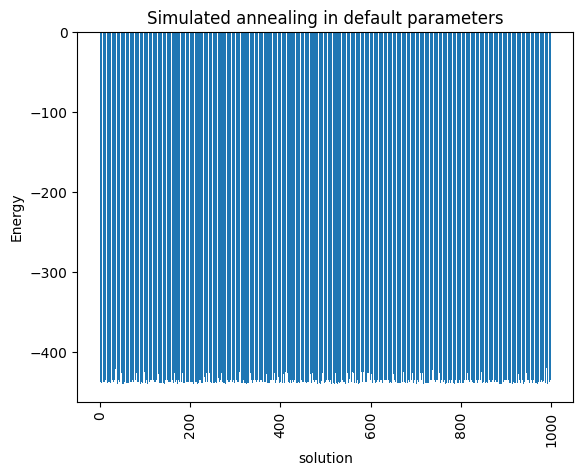

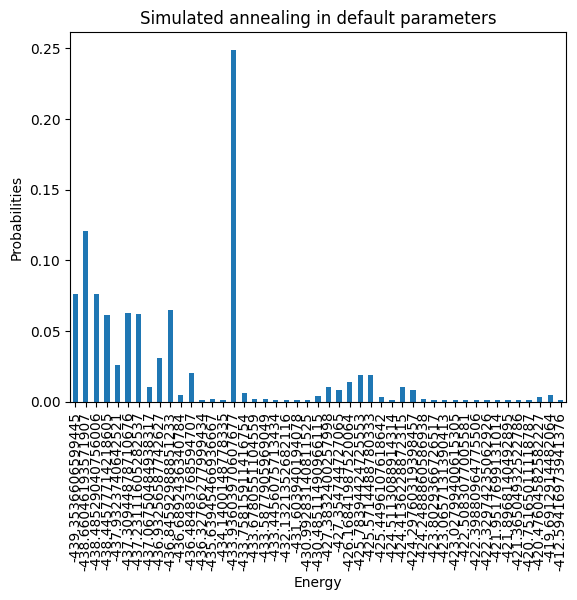

minimum energy: -439.3536606599445


In [22]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

We can solve this problem using IP such that we have guarantees that it is solved to optimality (this might be a great quiz for future lectures), but in this case let us define the "success" as getting an objective better than the one obtained using the default setting of Simulated annealing listed below plus some treshold of 5. To get a little more resolution we increase the number of reads to 5000.

In [23]:
simAnnSamples.info

{'beta_range': [0.006010317933083296, 106834.10703029361],
 'beta_schedule_type': 'geometric',
 'timing': {'preprocessing_ns': 52798200,
  'sampling_ns': 3866188500,
  'postprocessing_ns': 629800}}

Computing the expected computational time we obtain

In [24]:
s = 0.99
treshold = 5
sweeps = list(chain(np.arange(1,30,1)))
schedules = ['geometric','linear']
success = min_energy + treshold
p = {}
tts = {}
for schedule in schedules:
    probs = []
    time_to_sol = []
    for sweep in sweeps:
        start = time.time()
        samples = simAnnSampler.sample(model_random, num_reads=5000, num_sweeps=sweep, beta_schedule_type=schedule)
        if sweep == 1:
            tau = time.time() - start
        energies=samples.data_vectors['energy']
        occurrences = samples.data_vectors['num_occurrences']
        total_counts = sum(occurrences)
        counts = {}
        for index, energy in enumerate(energies):
            if energy in counts.keys():
                counts[energy] += occurrences[index]
            else:
                counts[energy] = occurrences[index]
        pr = sum(counts[key] for key in counts.keys() if key < success)/total_counts
        probs.append(pr)
        if pr == 0:
            time_to_sol.append(None)
        else:
            time_to_sol.append(sweep*tau*math.log10(1-s)/math.log10(1-pr))
    p[schedule] = probs
    tts[schedule] = time_to_sol

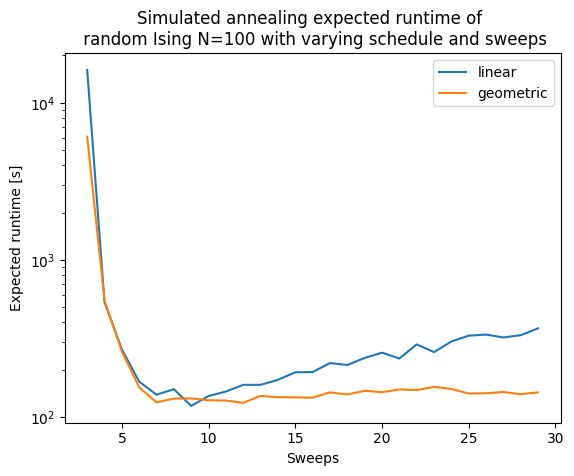

In [25]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.semilogy(sweeps,tts['linear'],'-', label='linear')
ax1.semilogy(sweeps,tts['geometric'],'-', label='geometric')
plt.ylabel('Expected runtime [s]')
plt.xlabel('Sweeps')
plt.title('Simulated annealing expected runtime of \n' + ' random Ising N=100 with varying schedule and sweeps')
plt.legend()